Testing how using different priors on the slope parameters changes posteriors

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

Define model function

In [52]:
def model(m, c, x):
    return m * x + c

Prior

In [53]:
def jake_lnprior(pars):
    alpha, beta, sigma = pars
    if sigma < 0:
        return -np.inf
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

In [54]:
def lnprior(pars):
    if -10 < pars[0] < 10 and -10 < pars[1] < 10 and -10 < pars[2] < 10:
        return 0.
    else:
        return -np.inf

Log prob

In [64]:
def jake_lnprob(pars, x, y, xerr, yerr):
    return jake_lnprior(pars) + lnlike(pars, x, y, xerr, yerr)

In [70]:
def lnprob(pars, x, y, xerr, yerr):
    return lnprior(pars) + lnlike(pars, x, y, xerr, yerr)

Likelihood

In [57]:
#def lnlike(theta, x, y, yerr):
#    m, c, s = theta
#    invsig2 = 1./(yerr**2 + s**2)
#    return -.5*np.sum((y-model(m, c, x))**2*invsig2 - np.log(invsig2))
#    #return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def lnlike(pars, x, y, xerr, yerr):
    m, b, s = pars
    sig2 = (m*xerr)**2 + (yerr**2 + s**2)
    ll = -.5 * np.sum((m*x-y+b)**2/sig2 + np.log(sig2))
    return ll

Plot the data

params =  -0.525509606298 2.88909102256


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


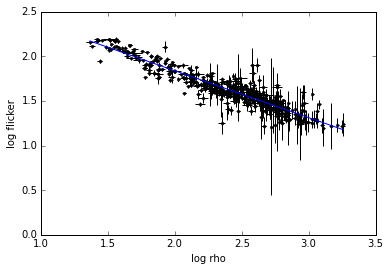

In [58]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

Run emcee

In [66]:
pars_init = [m, c, np.log(3)]

In [65]:
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, jake_lnprob, args=(r, f, rerr, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m2, c2, ln_sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(m2)
print(c2)
print(ln_sig2)

(-0.52577232246936534, 0.0092986532326049254, 0.0092004049865096471)
(2.8924409733388217, 0.021228754717149467, 0.021420135637409743)
(0.064825146015179747, 0.0029908479154770462, 0.0028101045287643872)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


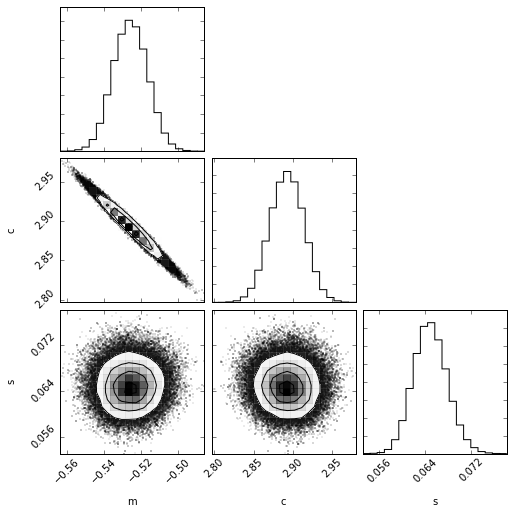

In [67]:
fig = corner.corner(samples, labels=["m", "c", "s"])

These results are consistent with the Uniform prior results

In [71]:
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, rerr, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m1, c1, ln_sig1 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(m1)
print(c1)
print(ln_sig1)

(-0.52592092272369162, 0.0090952116519138482, 0.0090763609552524382)
(2.8929034992149645, 0.020881012525562515, 0.021097894628154812)
(0.065004466168287728, 0.0030647040262609115, 0.0028679039029033682)


In [72]:
print((m1[0] - m2[0])/ m1[1])
print((c1[0] - c2[0])/ c1[1])
print((ln_sig1[0] - ln_sig2[0])/ ln_sig1[1])

-0.0163382953595
0.0221505482829
0.0585114097712


# Now for logg

params =  -0.826618949099 4.90659568177


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


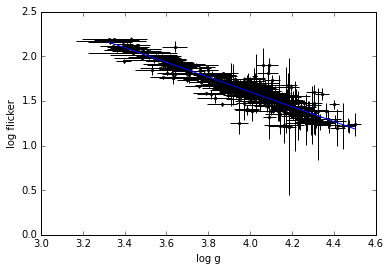

In [73]:
# load data
f, ferr, l, lerr, _, _ = np.genfromtxt("../data/log.dat").T

# fit a line
AT = np.vstack((l, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(l), max(l), 100)
ys = m * xs + c
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log g")

Jake first:

In [93]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, jake_lnprob, args=(l, f, lerr, ferr))
sampler.run_mcmc(pos, 20000)  # run MCMC
samples = sampler.chain[:, 19000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = samples[:, 2]
m1, c1, ln_sig1 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


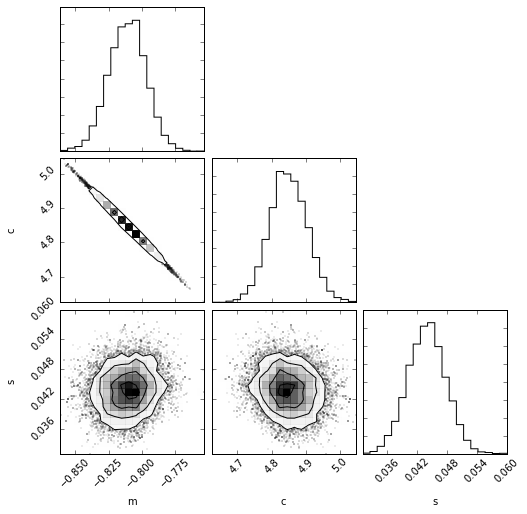

In [94]:
fig = corner.corner(samples, labels=["m", "c", "s"])

Then simple:

In [95]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, lerr, ferr))
sampler.run_mcmc(pos, 20000)  # run MCMC
samples = sampler.chain[:, 19000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m2, c2, ln_sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


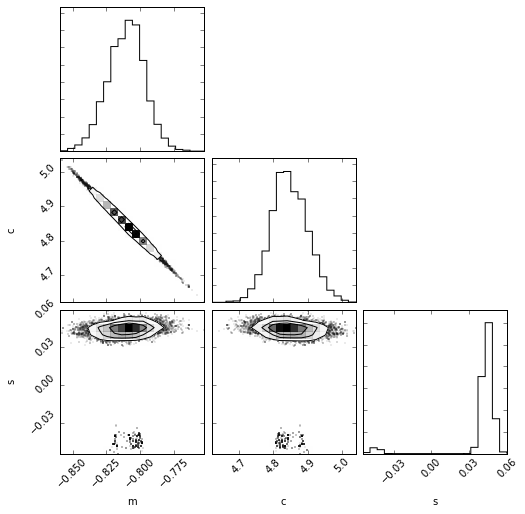

In [96]:
fig = corner.corner(samples, labels=["m", "c", "s"])

In [97]:
print((m1[0] - m2[0])/ m1[1])
print((c1[0] - c2[0])/ c1[1])
print((ln_sig1[0] - ln_sig2[0])/ ln_sig1[1])

-0.065689423226
0.0630132079208
-0.0360184866142
